<a href="https://colab.research.google.com/github/Fa7adbina/assessment1123/blob/main/Classify_facial_expressions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction
This notebook aims to perform facial expression recognition using deep learning models. We will be leveraging two models: a custom CNN model and a pre-trained VGG16 model. The dataset used contains images of facial expressions categorized into seven classes: angry, disgust, fear, happy, neutral, sad, and surprise.

# Data Loading
The following section involves loading the dataset.

In [ ]:
# from google.colab import files

# files.upload()

In [ ]:
! pip install -q kaggle
!pip install gradio
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d aadityasinghal/facial-expression-dataset
! unzip facial-expression-dataset.zip -d facial_expression

# Facial Expression Recognition Project

This notebook aims to explore and train models for facial expression recognition using two different approaches: a pre-trained VGG16 model and a custom Convolutional Neural Network (CNN) model. We will go through the following steps:
1. Data Loading and Preprocessing
2. Model Definition and Training
3. Error Analysis
4. Deployment using Gradio

## Model Comparison

### VGG16 Pre-trained Model
- **Architecture:** VGG16 is a deep convolutional neural network with 16 weight layers. It is known for its simplicity and effectiveness in image classification tasks.
- **Pre-trained Weights:** The VGG16 model is pre-trained on the ImageNet dataset, which contains over a million images and 1000 classes. This allows the model to leverage learned features and improve performance on the facial expression dataset through transfer learning.
- **Advantages:**
  - Utilizes pre-trained weights which help in faster convergence and improved accuracy.
  - Deep architecture enables the learning of complex features.
- **Disadvantages:**
  - Computationally expensive due to its depth and number of parameters.
  - Requires more resources (memory and processing power) for training and inference.

### Custom CNN Model
- **Architecture:** A simpler CNN model with three convolutional layers followed by max-pooling and fully connected layers.
- **Training from Scratch:** This model is trained from scratch on the facial expression dataset, without leveraging any pre-trained weights.
- **Advantages:**
  - Simpler and faster to train compared to VGG16.
  - Requires fewer computational resources.
- **Disadvantages:**
  - May not achieve the same level of accuracy as a deeper, pre-trained model like VGG16.
  - Requires more epochs and careful tuning to reach optimal performance.

### Which Model is Better?

The choice between VGG16 and a custom CNN depends on the specific requirements and constraints of your project:
- **Accuracy:** VGG16 typically offers better accuracy due to transfer learning and its deep architecture. If achieving the highest possible accuracy is critical, VGG16 is likely the better choice.
- **Resources:** If computational resources are limited, a custom CNN may be preferable due to its simplicity and lower resource requirements.
- **Training Time:** VGG16 may converge faster to a good performance level due to pre-trained weights, but overall training time might be longer due to its complexity.

In this notebook, we will implement both models and compare their performance to determine which is more suitable for the facial expression recognition task.

## Future Improvements

To further improve the performance of facial expression recognition models, consider the following suggestions:

1. **Use a More Advanced Pre-trained Model:** Models such as ResNet50, EfficientNet, or MobileNetV2 could potentially offer better performance compared to VGG16 due to their advanced architectures.
2. **Data Augmentation:** Implement more robust data augmentation techniques to artificially increase the size and variability of the training dataset, which can help in making the model more generalizable.
3. **Collect More Data:** Gather more labeled data, especially for underrepresented classes such as "disgust." This will help in balancing the dataset and improving model performance.

# First Model CNN

## Import

In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report

import gradio as gr


## EDA

          Train Count  Test Count
angry            3995         958
disgust           436         111
fear             4097        1024
happy            7215        1774
neutral          4965        1233
sad              4830        1247
surprise         3171         831
Total Train:  28709
Total Test:   7178
Training Dataset Samples


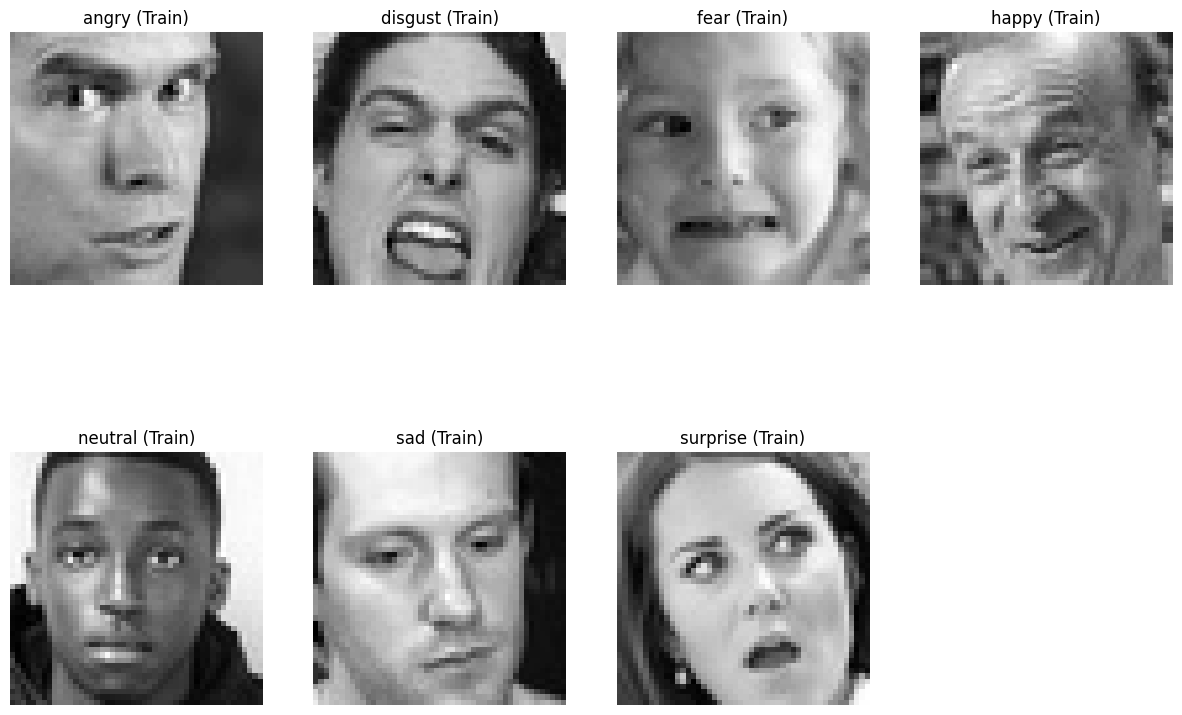

Testing Dataset Samples


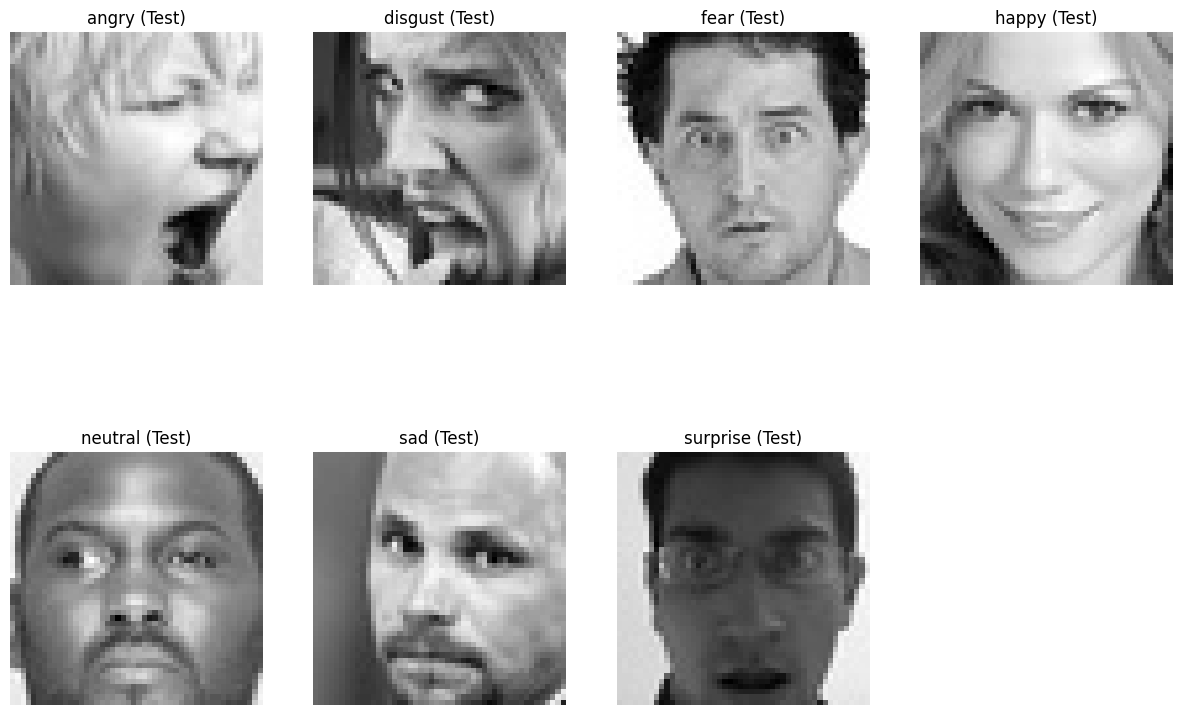

In [ ]:

# Base directories
base_dir_train = '/content/facial_expression/train/train'
base_dir_test = '/content/facial_expression/test/test'
categories = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

# Function to load images
def load_images(base_dir, categories):
    data = []
    labels = []
    for category in categories:
        category_path = os.path.join(base_dir, category)
        for img_name in os.listdir(category_path):
            img_path = os.path.join(category_path, img_name)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is not None:
                img = cv2.resize(img, (48, 48))
                img = img / 255.0  # Normalize the image
                img = np.expand_dims(img, axis=-1)  # Add channel dimension
                data.append(img)
                labels.append(categories.index(category))
    return np.array(data), np.array(labels)

# Load training and testing data
X_train, y_train = load_images(base_dir_train, categories)
X_test, y_test = load_images(base_dir_test, categories)

# Function to count images in each category
def count_images(base_dir, categories):
    counts = {}
    for category in categories:
        category_path = os.path.join(base_dir, category)
        counts[category] = len(os.listdir(category_path))
    return counts

# Function to show sample images
def show_sample_images(base_dir, categories, dataset_type):
    plt.figure(figsize=(15, 10))
    for i, category in enumerate(categories):
        category_path = os.path.join(base_dir, category)
        sample_image = os.listdir(category_path)[0]
        img_path = os.path.join(category_path, sample_image)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Read as grayscale
        img = cv2.resize(img, (48, 48))  # Resize to 48x48 pixels
        plt.subplot(2, len(categories) // 2 + 1, i + 1)
        plt.imshow(img, cmap='gray')
        plt.title(f'{category} ({dataset_type})')
        plt.axis('off')
    plt.show()

# Count images for training and testing datasets
train_counts = count_images(base_dir_train, categories)
test_counts = count_images(base_dir_test, categories)

# Create dataframes for better visualization
df_train_counts = pd.DataFrame.from_dict(train_counts, orient='index', columns=['Train Count'])
df_test_counts = pd.DataFrame.from_dict(test_counts, orient='index', columns=['Test Count'])

# Merge the dataframes
df_counts = pd.concat([df_train_counts, df_test_counts], axis=1)
print(df_counts)
print('Total Train: ', df_counts['Train Count'].sum())
print('Total Test:  ', df_counts['Test Count'].sum())

# Show sample images from training dataset
print("Training Dataset Samples")
show_sample_images(base_dir_train, categories, 'Train')

# Show sample images from testing dataset
print("Testing Dataset Samples")
show_sample_images(base_dir_test, categories, 'Test')


## Model Training, and Evaluation

In [ ]:
# Define the model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(7, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

# Train the model with callbacks
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_test, y_test),
                    callbacks=[early_stopping, reduce_lr])

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test accuracy: {accuracy}')

# Save the model
model.save('best_model_cnn.h5')

Epoch 1/20
898/898 [==============================] - 6s 5ms/step - loss: 1.7137 - accuracy: 0.3086 - val_loss: 1.5287 - val_accuracy: 0.4019 - lr: 0.0010
Epoch 2/20
898/898 [==============================] - 4s 4ms/step - loss: 1.4824 - accuracy: 0.4284 - val_loss: 1.3840 - val_accuracy: 0.4650 - lr: 0.0010
Epoch 3/20
898/898 [==============================] - 4s 4ms/step - loss: 1.3658 - accuracy: 0.4813 - val_loss: 1.2878 - val_accuracy: 0.5038 - lr: 0.0010
Epoch 4/20
898/898 [==============================] - 4s 4ms/step - loss: 1.2927 - accuracy: 0.5074 - val_loss: 1.2434 - val_accuracy: 0.5306 - lr: 0.0010
Epoch 5/20
898/898 [==============================] - 4s 4ms/step - loss: 1.2396 - accuracy: 0.5320 - val_loss: 1.1986 - val_accuracy: 0.5479 - lr: 0.0010
Epoch 6/20
898/898 [==============================] - 4s 4ms/step - loss: 1.1970 - accuracy: 0.5473 - val_loss: 1.1823 - val_accuracy: 0.5485 - lr: 0.0010
Epoch 7/20
898/898 [==============================] - 4s 4ms/step - lo

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Error Analysis


225/225 [==============================] - 0s 2ms/step


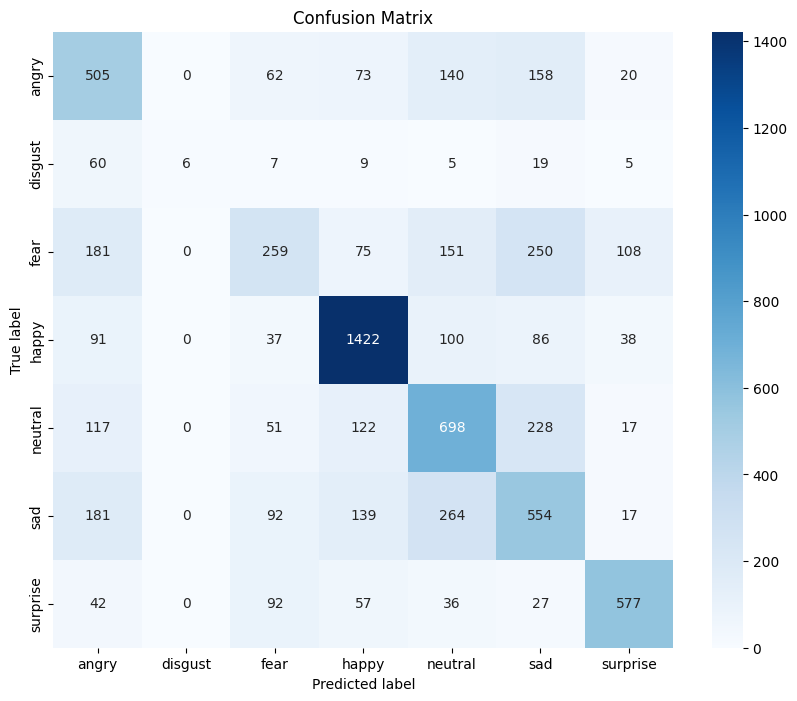

              precision    recall  f1-score   support

       angry       0.43      0.53      0.47       958
     disgust       1.00      0.05      0.10       111
        fear       0.43      0.25      0.32      1024
       happy       0.75      0.80      0.77      1774
     neutral       0.50      0.57      0.53      1233
         sad       0.42      0.44      0.43      1247
    surprise       0.74      0.69      0.72       831

    accuracy                           0.56      7178
   macro avg       0.61      0.48      0.48      7178
weighted avg       0.56      0.56      0.55      7178



In [ ]:
# Predict the test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=categories, yticklabels=categories)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()

# Classification report
print(classification_report(y_test, y_pred_classes, target_names=categories))


## Gradio Interface

In [ ]:
# Load the saved model
model = load_model('best_model_cnn.h5')

# Define emotion categories
categories = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

# Define the prediction function
def predict_emotion(image):
    # Ensure the image is in the right format
    if image.shape[-1] == 4:  # Handle alpha channel if present
        image = cv2.cvtColor(image, cv2.COLOR_BGRA2BGR)

    if image.shape[-1] == 3:  # If image has 3 channels, convert to grayscale
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    image = cv2.resize(image, (48, 48))  # Resize to 48x48 pixels
    image = np.expand_dims(image, axis=-1)  # Add channel dimension
    image = image / 255.0  # Normalize the image
    image = np.expand_dims(image, axis=0)  # Add batch dimension

    # Make prediction
    predictions = model.predict(image)
    predicted_class = categories[np.argmax(predictions)]

    return predicted_class

# Set up the Gradio interface
interface = gr.Interface(
    fn=predict_emotion,
    inputs=gr.Image(image_mode='L'),
    outputs=gr.Label(),
    title="Facial Expression Recognition",
    description="Upload an image and the model will predict the facial expression."
)

# Launch the interface
interface.launch(debug=True)


Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Running on public URL: https://ad9d83578b31fa308b.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


1/1 [==============================] - 0s 20ms/step
Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://ad9d83578b31fa308b.gradio.live


# Second model - VGG16 Pre-trained Model

## Import

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# Clone the repository
!git clone https://github.com/WuJie1010/Facial-Expression-Recognition.Pytorch.git
%cd Facial-Expression-Recognition.Pytorch

Cloning into 'Facial-Expression-Recognition.Pytorch'...
remote: Enumerating objects: 1161, done.
remote: Total 1161 (delta 0), reused 0 (delta 0), pack-reused 1161
Receiving objects: 100% (1161/1161), 5.41 MiB | 7.39 MiB/s, done.
Resolving deltas: 100% (80/80), done.
/content/Facial-Expression-Recognition.Pytorch


## EDA

          Train Count  Test Count
angry            3995         958
disgust           436         111
fear             4097        1024
happy            7215        1774
neutral          4965        1233
sad              4830        1247
surprise         3171         831
Total Train:  28709
Total Test:   7178


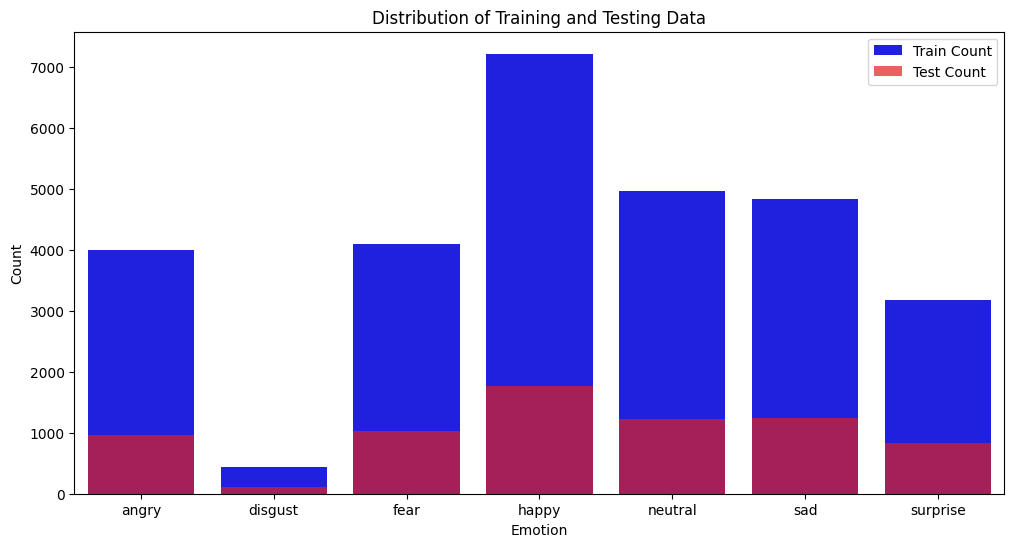

In [ ]:
# Configuration for VGG16
cfg = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M']

# Data loading
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_data = ImageFolder(root='/content/facial_expression/train/train', transform=transform)
test_data = ImageFolder(root='/content/facial_expression/test/test', transform=transform)
train_loader = DataLoader(train_data, batch_size=128, shuffle=True)
test_loader = DataLoader(test_data, batch_size=128, shuffle=False)

# Function to count images in each category
def count_images(dataset):
    counts = {}
    for _, label in dataset.imgs:
        label_name = train_data.classes[label]
        if label_name not in counts:
            counts[label_name] = 0
        counts[label_name] += 1
    return counts

# Count images for training and testing datasets
train_counts = count_images(train_data)
test_counts = count_images(test_data)

# Create dataframes for better visualization
df_train_counts = pd.DataFrame.from_dict(train_counts, orient='index', columns=['Train Count'])
df_test_counts = pd.DataFrame.from_dict(test_counts, orient='index', columns=['Test Count'])

# Merge the dataframes
df_counts = pd.concat([df_train_counts, df_test_counts], axis=1)
print(df_counts)
print('Total Train: ', df_counts['Train Count'].sum())
print('Total Test:  ', df_counts['Test Count'].sum())

# Visualize the data distribution
plt.figure(figsize=(12, 6))
sns.barplot(x=df_counts.index, y=df_counts['Train Count'], color='blue', label='Train Count')
sns.barplot(x=df_counts.index, y=df_counts['Test Count'], color='red', label='Test Count', alpha=0.7)
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.title('Distribution of Training and Testing Data')
plt.legend()
plt.show()


## Model Training, and Evaluation

In [ ]:
# VGG16 Model Definition
class VGG(nn.Module):
    def __init__(self, features):
        super(VGG, self).__init__()
        self.features = features
        self.classifier = nn.Linear(512 * 7 * 7, 7)  # Assuming 7 classes for facial expressions

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.classifier(x)
        return x

def make_layers(cfg, batch_norm=True):
    layers = []
    in_channels = 3
    for v in cfg:
        if v == 'M':
            layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            if batch_norm:
                layers.extend([conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)])
            else:
                layers.extend([conv2d, nn.ReLU(inplace=True)])
            in_channels = v
    return nn.Sequential(*layers)

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Model setup
vgg16 = VGG(make_layers(cfg)).to(device)

# Load pre-trained weights (if available)
# Uncomment the line below to load pre-trained weights
# vgg16.load_state_dict(torch.load('/path/to/pretrained/weights.pth'))

# Fine-tuning setup
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vgg16.parameters(), lr=0.0001)  # Adjusted learning rate for fine-tuning

# Training loop
num_epochs = 20  # Adjusted number of epochs
for epoch in range(num_epochs):
    vgg16.train()
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = vgg16(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    print(f'Epoch {epoch+1}, Loss: {loss.item()}')

# Evaluation
vgg16.eval()
total_correct = 0
total_images = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = vgg16(images)
        _, predicted = torch.max(outputs.data, 1)
        total_correct += (predicted == labels).sum().item()
        total_images += labels.size(0)

print(f'Accuracy: {total_correct / total_images * 100:.2f}%')

# Save the entire model
torch.save(vgg16, '/content/vgg16_full_model.pth')

# Save only the state dictionary
torch.save(vgg16.state_dict(), '/content/vgg16_state_dict.pth')

Epoch 1, Loss: 1.1990108489990234
Epoch 2, Loss: 1.3734318017959595
Epoch 3, Loss: 1.1504504680633545
Epoch 4, Loss: 1.1061724424362183
Epoch 5, Loss: 1.0513043403625488
Epoch 6, Loss: 0.8298842310905457
Epoch 7, Loss: 0.5656203031539917
Epoch 8, Loss: 0.9579761624336243
Epoch 9, Loss: 0.5635977983474731
Epoch 10, Loss: 0.7201523780822754
Epoch 11, Loss: 0.4921157956123352
Epoch 12, Loss: 0.3770357668399811
Epoch 13, Loss: 0.42363062500953674
Epoch 14, Loss: 0.28611889481544495
Epoch 15, Loss: 0.41094887256622314
Epoch 16, Loss: 0.17362135648727417
Epoch 17, Loss: 0.28807514905929565
Epoch 18, Loss: 0.2064134031534195
Epoch 19, Loss: 0.29466712474823
Epoch 20, Loss: 0.1048951968550682
Accuracy: 60.99%


## Error Analysis

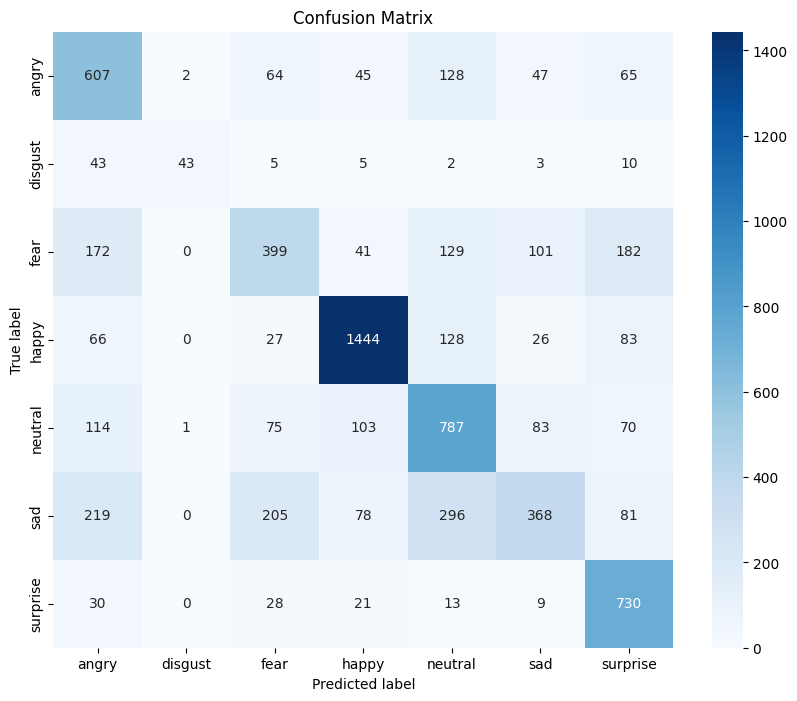

              precision    recall  f1-score   support

       angry       0.49      0.63      0.55       958
     disgust       0.93      0.39      0.55       111
        fear       0.50      0.39      0.44      1024
       happy       0.83      0.81      0.82      1774
     neutral       0.53      0.64      0.58      1233
         sad       0.58      0.30      0.39      1247
    surprise       0.60      0.88      0.71       831

    accuracy                           0.61      7178
   macro avg       0.64      0.58      0.58      7178
weighted avg       0.62      0.61      0.60      7178



In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

# Function to convert dataloader to arrays
def dataloader_to_arrays(dataloader):
    images = []
    labels = []
    preds = []
    with torch.no_grad():
        for data in dataloader:
            inputs, labels_batch = data
            inputs, labels_batch = inputs.to(device), labels_batch.to(device)
            outputs = vgg16(inputs)
            _, predicted = torch.max(outputs.data, 1)
            images.append(inputs.cpu().numpy())
            labels.append(labels_batch.cpu().numpy())
            preds.append(predicted.cpu().numpy())
    return np.concatenate(images), np.concatenate(labels), np.concatenate(preds)

# Get arrays from dataloader
X_test, y_test, y_pred = dataloader_to_arrays(test_loader)

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=train_data.classes, yticklabels=train_data.classes)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()

# Classification report
print(classification_report(y_test, y_pred, target_names=train_data.classes))


## Gradio Interface

In [ ]:
import gradio as gr
from PIL import Image

# Define the prediction function
def predict_emotion(image):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    image = transform(image).unsqueeze(0).to(device)
    with torch.no_grad():
        outputs = vgg16(image)
        _, predicted = torch.max(outputs.data, 1)
    return train_data.classes[predicted.item()]

# Set up the Gradio interface
interface = gr.Interface(
    fn=predict_emotion,
    inputs=gr.Image(type='pil'),
    outputs=gr.Label(),
    title="Facial Expression Recognition",
    description="Upload an image and the model will predict the facial expression."
)

# Launch the interface
interface.launch(debug=True)


Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Running on public URL: https://ebce1553378b7abdce.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/gradio/queueing.py", line 536, in process_events
    response = await route_utils.call_process_api(
  File "/usr/local/lib/python3.10/dist-packages/gradio/route_utils.py", line 276, in call_process_api
    output = await app.get_blocks().process_api(
  File "/usr/local/lib/python3.10/dist-packages/gradio/blocks.py", line 1897, in process_api
    result = await self.call_function(
  File "/usr/local/lib/python3.10/dist-packages/gradio/blocks.py", line 1483, in call_function
    prediction = await anyio.to_thread.run_sync(
  File "/usr/local/lib/python3.10/dist-packages/anyio/to_thread.py", line 33, in run_sync
    return await get_asynclib().run_sync_in_worker_thread(
  File "/usr/local/lib/python3.10/dist-packages/anyio/_backends/_asyncio.py", line 877, in run_sync_in_worker_thread
    return await future
  File "/usr/local/lib/python3.10/dist-packages/anyio/_backends/_asyncio.py", line 807, in run
    r

Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://ebce1553378b7abdce.gradio.live
